In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

from statsmodels.tools.eval_measures import rmse
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('datasets/podzielone/ml/wszystkie/train_ml.csv', index_col=0)
val1 = pd.read_csv('datasets/podzielone/ml/wszystkie/valid1_ml.csv', index_col=0)
val2 = pd.read_csv('datasets/podzielone/ml/wszystkie/valid2_ml.csv', index_col=0)
val3 = pd.read_csv('datasets/podzielone/ml/wszystkie/valid3_ml.csv', index_col=0)
test = pd.read_csv('datasets/podzielone/ml/wszystkie/test_ml.csv', index_col=0)




train.index = pd.to_datetime(train.index)
val1.index = pd.to_datetime(val1.index)
val2.index = pd.to_datetime(val2.index)
val3.index = pd.to_datetime(val3.index)
test.index = pd.to_datetime(test.index)


train["day_of_week"] = train.index.dayofweek
train["day_of_year"] = train.index.dayofweek
train["week"] = train.index.week
train["quarter"] = train.index.quarter
train["return_ratio"] = train.y_return_ratio.shift()

val1["day_of_week"] = val1.index.dayofweek
val1["day_of_year"] = val1.index.dayofweek
val1["week"] = val1.index.week
val1["quarter"] = val1.index.quarter
val1["return_ratio"] = val1.y_return_ratio.shift()

val2["day_of_week"] = val2.index.dayofweek
val2["day_of_year"] = val2.index.dayofweek
val2["week"] = val2.index.week
val2["quarter"] = val2.index.quarter
val2["return_ratio"] = val2.y_return_ratio.shift()

val3["day_of_week"] = val3.index.dayofweek
val3["day_of_year"] = val3.index.dayofweek
val3["week"] = val3.index.week
val3["quarter"] = val3.index.quarter
val3["return_ratio"] = val3.y_return_ratio.shift()

test["day_of_week"] = test.index.dayofweek
test["day_of_year"] = test.index.dayofweek
test["week"] = test.index.week
test["quarter"] = test.index.quarter
test["return_ratio"] = test.y_return_ratio.shift()


train.columns=train.columns.str.replace('(','')
train.columns=train.columns.str.replace(']','')

val1.columns=val1.columns.str.replace('(','')
val1.columns=val1.columns.str.replace(']','')
val2.columns=val2.columns.str.replace('(','')
val2.columns=val2.columns.str.replace(']','')
val3.columns=val3.columns.str.replace('(','')
val3.columns=val3.columns.str.replace(']','')

test.columns=test.columns.str.replace('(','')
test.columns=test.columns.str.replace(']','')

whole = pd.concat([train, val1, val2, val3, test]).asfreq('B', method='bfill').fillna(method='bfill')
val = pd.concat([val1, val2, val3]).asfreq('B', method='bfill').fillna(method='bfill')

val.columns=val.columns.str.replace('(','')
val.columns=val.columns.str.replace(']','')

train1 = train.asfreq('B', method='bfill').fillna(method='bfill')
train2 = pd.concat([train, val1]).asfreq('B', method='bfill').fillna(method='bfill')
train3 = pd.concat([train, val1, val2]).asfreq('B', method='bfill').fillna(method='bfill')

val1 = val1.asfreq('B', method='bfill').fillna(method='bfill')
val2 = val2.asfreq('B', method='bfill').fillna(method='bfill')
val3 = val3.asfreq('B', method='bfill').fillna(method='bfill')
test = test.asfreq('B', method='bfill').fillna(method='bfill')



display(train.head(3))
display(val1.head(3))
display(val2.head(3))
display(val3.head(3))
display(test.head(3))
display(whole.head(3))

,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2012-07-02,-0.026773,0.475985,1.53,148.118434,12.781515,62.987843,-1.546392,59.313104,31.365741,2.350220,...,0.003153,0.0,0.0,0.042874,0.018620,0.078845,0,0,27,3
2012-07-03,0.026022,0.481986,1.05,103.024634,12.824644,57.664648,-22.613065,52.602204,23.907183,2.182347,...,-0.001980,0.0,0.0,-0.027138,-0.011786,-0.050102,1,1,27,3
2012-07-05,-0.010145,0.475416,0.56,110.859729,12.887570,61.020501,-5.025126,57.027455,23.907183,2.026465,...,0.001876,0.0,0.0,0.025689,0.011157,0.047411,3,3,27,3


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-01-02,0.030233,5.125354,7.029999,27.231458,196.912948,45.133485,-42.095010,55.894280,23.134279,13.144963,...,-0.000102,-4.0,-4.0,-0.019955,-0.008666,-0.139483,1,1,1,1
2018-01-03,0.065814,5.187829,7.790008,77.718696,197.070178,53.249819,-4.033801,55.819341,19.229973,13.246030,...,0.000152,6.0,6.0,0.029785,0.012935,0.208708,2,2,1,1
2018-01-04,0.005271,5.842269,14.570007,279.927608,198.063715,65.556102,-4.226792,67.077304,18.683056,26.499882,...,0.000310,13.0,13.0,0.063739,0.027681,0.457215,3,3,1,1


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-03-01,-0.040455,8.425720,9.369995,37.127358,234.729083,54.963241,-28.932093,70.942953,2.299899,24.419310,...,-0.000068,-5.0,-4.0,-0.016638,-0.007226,-0.129951,3,3,9,1
2018-03-02,0.018647,8.964597,-9.209991,-67.945451,234.566562,47.416343,-57.358478,71.264678,24.198760,22.675074,...,-0.000174,-9.0,-10.0,-0.041296,-0.017934,-0.317911,4,4,9,1
2018-03-05,-0.003763,9.392126,-9.960007,-108.267191,234.693880,50.644262,-51.228455,60.063802,31.886239,21.055426,...,0.000079,4.0,4.0,0.018475,0.008024,0.141418,0,0,10,1


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-05-01,0.009960,8.606211,-6.590011,-36.196616,229.129258,46.714722,-49.568247,52.298305,16.163336,22.665165,...,-0.000028,-2.0,-2.0,-0.006338,-0.002753,-0.047602,1,1,18,2
2018-05-02,-0.003654,8.352196,-10.399994,-41.609464,229.000918,48.681141,-41.830750,46.410723,19.251258,21.046224,...,0.000044,3.0,3.0,0.009911,0.004304,0.074498,2,2,18,2
2018-05-03,0.029517,8.009182,-10.059997,-16.440286,228.827311,47.974668,-44.697766,43.162233,15.551078,21.092926,...,-0.000016,-1.0,-1.0,-0.003661,-0.001590,-0.027561,3,3,18,2


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2018-07-02,0.022541,6.899792,-28.360016,-97.965938,250.580128,36.289331,-94.472074,39.345807,40.019379,13.617902,...,-0.000069,-4.0,-4.0,-0.016578,-0.007200,-0.128109,0,0,27,3
2018-07-03,-0.022292,7.059093,-22.849991,-81.994860,250.042056,42.388575,-75.013896,39.426792,44.725629,12.645195,...,0.000093,6.0,6.0,0.022291,0.009681,0.172505,1,1,27,3
2018-07-04,0.024869,7.082015,-23.330017,-71.397983,249.190310,38.386549,-90.038956,34.350825,39.822012,13.231972,...,-0.000094,-6.0,-6.0,-0.022544,-0.009791,-0.174455,3,3,27,3


,y_return_ratio,ATR,MOM,CCI,EMA,RSI,Will_R,MFI,DX,PLUS_DM,...,ATAN_diff_1,CEIL_diff_1,FLOOR_diff_1,LN_diff_1,LOG10_diff_1,SQRT_diff_1,day_of_week,day_of_year,week,quarter
2012-07-02,-0.026773,0.475985,1.53,148.118434,12.781515,62.987843,-1.546392,59.313104,31.365741,2.350220,...,0.003153,0.0,0.0,0.042874,0.018620,0.078845,0,0,27,3
2012-07-03,0.026022,0.481986,1.05,103.024634,12.824644,57.664648,-22.613065,52.602204,23.907183,2.182347,...,-0.001980,0.0,0.0,-0.027138,-0.011786,-0.050102,1,1,27,3
2012-07-04,-0.010145,0.475416,0.56,110.859729,12.887570,61.020501,-5.025126,57.027455,23.907183,2.026465,...,0.001876,0.0,0.0,0.025689,0.011157,0.047411,3,3,27,3


In [4]:
S = [(train1, val1), (train2, val2), (train3, val3)]

In [5]:
variables = train.columns.tolist()
variables.remove("y_return_ratio")
features = train[variables].columns
target = 'y_return_ratio'

# Korelacje Spearmana

In [6]:
corr_matrix = whole.drop(columns=['y_return_ratio']).corr("spearman").abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

var1 = [col for col in upper.columns if upper[col].max() < 0.9]
var2 = [col for col in upper.columns if upper[col].max() < 0.7]
var3 = [col for col in upper.columns if upper[col].max() < 0.5]
var4 = [col for col in upper.columns if upper[col].max() < 0.4]
var5 = [col for col in upper.columns if upper[col].max() < 0.3]

print(len(var1))
print(len(var2))
print(len(var3))
print(len(var4))

print(len(var5))

191
128
100
78
57


# ExtraTreesRegression

In [7]:
X_train1 = train1[var5]
y_train1 = train1[target]
X_test1 = val[var5]
y_test1 = val[target]

model = ExtraTreesRegressor()
model.fit(X_train1, y_train1)
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
ATVI_gaming_rr,0.084360
TAN,0.063906
MOM,0.060310
return_ratio_shift_7,0.059754
inventory_turnover_ratio,0.053815
UBSFY_gaming_rr,0.053806
BETA,0.051003
UBSFY_gaming_rolling_variance,0.049723
SIN,0.049112
gaming_news_diff_1_shift_2,0.047541


# LSTM

Train on 1549 samples, validate on 16 samples
Epoch 1/120
1549/1549 [==============================] - 42s 27ms/step - loss: 0.1477 - val_loss: 0.1334
Epoch 2/120
1549/1549 [==============================] - 0s 148us/step - loss: 0.1138 - val_loss: 0.1792
Epoch 3/120
1549/1549 [==============================] - 0s 111us/step - loss: 0.1013 - val_loss: 0.1039
Epoch 4/120
1549/1549 [==============================] - 0s 122us/step - loss: 0.0978 - val_loss: 0.1250
Epoch 5/120
1549/1549 [==============================] - 0s 143us/step - loss: 0.0953 - val_loss: 0.1199
Epoch 6/120
1549/1549 [==============================] - 0s 131us/step - loss: 0.0933 - val_loss: 0.0921
Epoch 7/120
1549/1549 [==============================] - 0s 137us/step - loss: 0.0914 - val_loss: 0.0938
Epoch 8/120
1549/1549 [==============================] - 0s 115us/step - loss: 0.0894 - val_loss: 0.0884
Epoch 9/120
1549/1549 [==============================] - 0s 124us/step - loss: 0.0874 - val_loss: 0.0999
Epoch 10/

1549/1549 [==============================] - 0s 134us/step - loss: 0.0175 - val_loss: 0.0165
Epoch 79/120
1549/1549 [==============================] - 0s 125us/step - loss: 0.0170 - val_loss: 0.0190
Epoch 80/120
1549/1549 [==============================] - 0s 91us/step - loss: 0.0166 - val_loss: 0.0193
Epoch 81/120
1549/1549 [==============================] - 0s 85us/step - loss: 0.0162 - val_loss: 0.0176
Epoch 82/120
1549/1549 [==============================] - 0s 91us/step - loss: 0.0158 - val_loss: 0.0145
Epoch 83/120
1549/1549 [==============================] - 0s 119us/step - loss: 0.0153 - val_loss: 0.0157
Epoch 84/120
1549/1549 [==============================] - 0s 145us/step - loss: 0.0150 - val_loss: 0.0154
Epoch 85/120
1549/1549 [==============================] - 0s 161us/step - loss: 0.0146 - val_loss: 0.0249
Epoch 86/120
1549/1549 [==============================] - 0s 139us/step - loss: 0.0142 - val_loss: 0.0220
Epoch 87/120
1549/1549 [==============================] - 0s 1

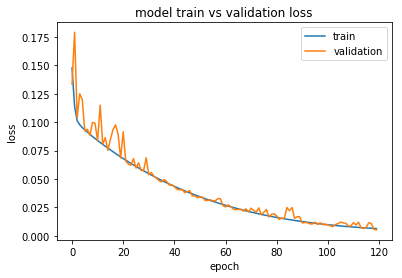

[0.0018289835]
0 131
Train on 1550 samples, validate on 16 samples
Epoch 1/120
1550/1550 [==============================] - 41s 26ms/step - loss: 0.1529 - val_loss: 0.1454
Epoch 2/120
1550/1550 [==============================] - 0s 107us/step - loss: 0.1300 - val_loss: 0.1068
Epoch 3/120
1550/1550 [==============================] - 0s 122us/step - loss: 0.1117 - val_loss: 0.1093
Epoch 4/120
1550/1550 [==============================] - 0s 95us/step - loss: 0.1011 - val_loss: 0.0974
Epoch 5/120
1550/1550 [==============================] - 0s 98us/step - loss: 0.0966 - val_loss: 0.1127
Epoch 6/120
1550/1550 [==============================] - 0s 111us/step - loss: 0.0937 - val_loss: 0.1103
Epoch 7/120
1550/1550 [==============================] - 0s 106us/step - loss: 0.0915 - val_loss: 0.0903
Epoch 8/120
1550/1550 [==============================] - 0s 86us/step - loss: 0.0894 - val_loss: 0.0903
Epoch 9/120
1550/1550 [==============================] - 0s 115us/step - loss: 0.0876 - val_loss

1550/1550 [==============================] - 0s 112us/step - loss: 0.0174 - val_loss: 0.0166
Epoch 79/120
1550/1550 [==============================] - 0s 117us/step - loss: 0.0170 - val_loss: 0.0162
Epoch 80/120
1550/1550 [==============================] - 0s 112us/step - loss: 0.0166 - val_loss: 0.0165
Epoch 81/120
1550/1550 [==============================] - 0s 110us/step - loss: 0.0161 - val_loss: 0.0155
Epoch 82/120
1550/1550 [==============================] - 0s 110us/step - loss: 0.0157 - val_loss: 0.0172
Epoch 83/120
1550/1550 [==============================] - 0s 103us/step - loss: 0.0153 - val_loss: 0.0146
Epoch 84/120
1550/1550 [==============================] - 0s 110us/step - loss: 0.0149 - val_loss: 0.0151
Epoch 85/120
1550/1550 [==============================] - 0s 103us/step - loss: 0.0145 - val_loss: 0.0139
Epoch 86/120
1550/1550 [==============================] - 0s 97us/step - loss: 0.0142 - val_loss: 0.0133
Epoch 87/120
1550/1550 [==============================] - 0s

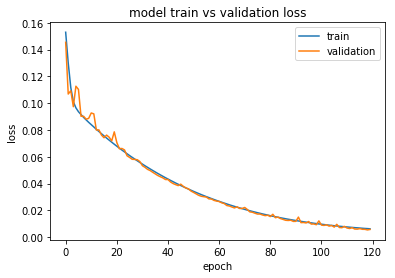

[0.0018289835, 0.0041467207]
1 131
Train on 1551 samples, validate on 16 samples
Epoch 1/120
1551/1551 [==============================] - 41s 26ms/step - loss: 0.1300 - val_loss: 0.3887
Epoch 2/120
1551/1551 [==============================] - 0s 89us/step - loss: 0.1074 - val_loss: 0.2567
Epoch 3/120
1551/1551 [==============================] - 0s 84us/step - loss: 0.1014 - val_loss: 0.5507
Epoch 4/120
1551/1551 [==============================] - 0s 86us/step - loss: 0.0980 - val_loss: 0.4676
Epoch 5/120
1551/1551 [==============================] - 0s 85us/step - loss: 0.0958 - val_loss: 0.2308
Epoch 6/120
1551/1551 [==============================] - 0s 87us/step - loss: 0.0935 - val_loss: 0.1510
Epoch 7/120
1551/1551 [==============================] - 0s 88us/step - loss: 0.0915 - val_loss: 0.1080
Epoch 8/120
1551/1551 [==============================] - 0s 104us/step - loss: 0.0895 - val_loss: 0.0882
Epoch 9/120
1551/1551 [==============================] - 0s 88us/step - loss: 0.0877 

1551/1551 [==============================] - 0s 86us/step - loss: 0.0175 - val_loss: 0.0169
Epoch 79/120
1551/1551 [==============================] - 0s 85us/step - loss: 0.0171 - val_loss: 0.0164
Epoch 80/120
1551/1551 [==============================] - 0s 83us/step - loss: 0.0166 - val_loss: 0.0156
Epoch 81/120
1551/1551 [==============================] - 0s 83us/step - loss: 0.0162 - val_loss: 0.0173
Epoch 82/120
1551/1551 [==============================] - 0s 83us/step - loss: 0.0158 - val_loss: 0.0191
Epoch 83/120
1551/1551 [==============================] - 0s 83us/step - loss: 0.0154 - val_loss: 0.0159
Epoch 84/120
1551/1551 [==============================] - 0s 86us/step - loss: 0.0150 - val_loss: 0.0173
Epoch 85/120
1551/1551 [==============================] - 0s 87us/step - loss: 0.0146 - val_loss: 0.0148
Epoch 86/120
1551/1551 [==============================] - 0s 84us/step - loss: 0.0143 - val_loss: 0.0148
Epoch 87/120
1551/1551 [==============================] - 0s 87us/st

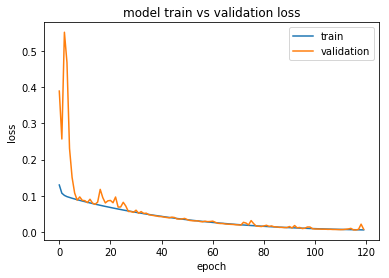

[0.0018289835, 0.0041467207, 0.01602321]
2 131
Train on 1552 samples, validate on 16 samples
Epoch 1/120
1552/1552 [==============================] - 42s 27ms/step - loss: 0.1439 - val_loss: 0.1430
Epoch 2/120
1552/1552 [==============================] - 0s 92us/step - loss: 0.1103 - val_loss: 0.1771
Epoch 3/120
1552/1552 [==============================] - 0s 115us/step - loss: 0.1017 - val_loss: 0.0997
Epoch 4/120
1552/1552 [==============================] - 0s 105us/step - loss: 0.0984 - val_loss: 0.1118
Epoch 5/120
1552/1552 [==============================] - 0s 86us/step - loss: 0.0955 - val_loss: 0.1183
Epoch 6/120
1552/1552 [==============================] - 0s 87us/step - loss: 0.0935 - val_loss: 0.0989
Epoch 7/120
1552/1552 [==============================] - 0s 88us/step - loss: 0.0914 - val_loss: 0.0942
Epoch 8/120
1552/1552 [==============================] - 0s 118us/step - loss: 0.0894 - val_loss: 0.0880
Epoch 9/120
1552/1552 [==============================] - 0s 107us/step 

Epoch 78/120
1552/1552 [==============================] - 0s 116us/step - loss: 0.0175 - val_loss: 0.0170
Epoch 79/120
1552/1552 [==============================] - 0s 100us/step - loss: 0.0170 - val_loss: 0.0172
Epoch 80/120
1552/1552 [==============================] - 0s 106us/step - loss: 0.0166 - val_loss: 0.0161
Epoch 81/120
1552/1552 [==============================] - 0s 119us/step - loss: 0.0162 - val_loss: 0.0156
Epoch 82/120
1552/1552 [==============================] - 0s 91us/step - loss: 0.0158 - val_loss: 0.0185
Epoch 83/120
1552/1552 [==============================] - 0s 106us/step - loss: 0.0154 - val_loss: 0.0161
Epoch 84/120
1552/1552 [==============================] - 0s 113us/step - loss: 0.0150 - val_loss: 0.0152
Epoch 85/120
1552/1552 [==============================] - 0s 97us/step - loss: 0.0146 - val_loss: 0.0141
Epoch 86/120
1552/1552 [==============================] - 0s 108us/step - loss: 0.0143 - val_loss: 0.0162
Epoch 87/120
1552/1552 [========================

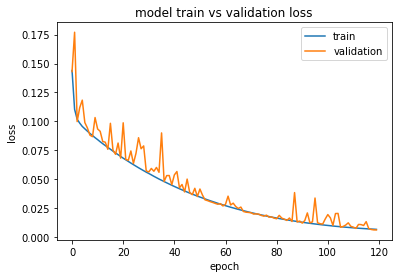

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819]
3 131
Train on 1553 samples, validate on 16 samples
Epoch 1/120
1553/1553 [==============================] - 42s 27ms/step - loss: 0.1499 - val_loss: 0.2323
Epoch 2/120
1553/1553 [==============================] - 0s 89us/step - loss: 0.1181 - val_loss: 0.6631
Epoch 3/120
1553/1553 [==============================] - 0s 89us/step - loss: 0.1037 - val_loss: 0.1122
Epoch 4/120
1553/1553 [==============================] - 0s 85us/step - loss: 0.0989 - val_loss: 0.2174
Epoch 5/120
1553/1553 [==============================] - 0s 125us/step - loss: 0.0954 - val_loss: 0.2122
Epoch 6/120
1553/1553 [==============================] - 0s 112us/step - loss: 0.0932 - val_loss: 0.1781
Epoch 7/120
1553/1553 [==============================] - 0s 97us/step - loss: 0.0911 - val_loss: 0.2008
Epoch 8/120
1553/1553 [==============================] - 0s 158us/step - loss: 0.0893 - val_loss: 0.1740
Epoch 9/120
1553/1553 [==============================] -

1553/1553 [==============================] - 0s 128us/step - loss: 0.0179 - val_loss: 0.0228
Epoch 78/120
1553/1553 [==============================] - 0s 101us/step - loss: 0.0175 - val_loss: 0.0314
Epoch 79/120
1553/1553 [==============================] - 0s 102us/step - loss: 0.0170 - val_loss: 0.0360
Epoch 80/120
1553/1553 [==============================] - 0s 95us/step - loss: 0.0166 - val_loss: 0.0186
Epoch 81/120
1553/1553 [==============================] - 0s 98us/step - loss: 0.0162 - val_loss: 0.0171
Epoch 82/120
1553/1553 [==============================] - 0s 92us/step - loss: 0.0158 - val_loss: 0.0166
Epoch 83/120
1553/1553 [==============================] - 0s 95us/step - loss: 0.0153 - val_loss: 0.0155
Epoch 84/120
1553/1553 [==============================] - 0s 94us/step - loss: 0.0150 - val_loss: 0.0158
Epoch 85/120
1553/1553 [==============================] - 0s 97us/step - loss: 0.0146 - val_loss: 0.0144
Epoch 86/120
1553/1553 [==============================] - 0s 97us

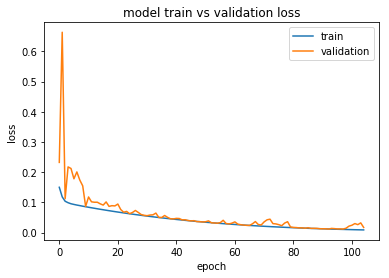

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233]
4 131
Train on 1554 samples, validate on 16 samples
Epoch 1/120
1554/1554 [==============================] - 43s 27ms/step - loss: 0.1525 - val_loss: 0.1026
Epoch 2/120
1554/1554 [==============================] - 0s 99us/step - loss: 0.1296 - val_loss: 0.5047
Epoch 3/120
1554/1554 [==============================] - 0s 146us/step - loss: 0.1127 - val_loss: 0.2986
Epoch 4/120
1554/1554 [==============================] - 0s 102us/step - loss: 0.1031 - val_loss: 0.1159
Epoch 5/120
1554/1554 [==============================] - 0s 129us/step - loss: 0.0974 - val_loss: 0.1073
Epoch 6/120
1554/1554 [==============================] - 0s 104us/step - loss: 0.0938 - val_loss: 0.1367
Epoch 7/120
1554/1554 [==============================] - 0s 97us/step - loss: 0.0914 - val_loss: 0.0930
Epoch 8/120
1554/1554 [==============================] - 0s 105us/step - loss: 0.0893 - val_loss: 0.0955
Epoch 9/120
1554/1554 [=================

1554/1554 [==============================] - 0s 101us/step - loss: 0.0179 - val_loss: 0.0179
Epoch 78/120
1554/1554 [==============================] - 0s 95us/step - loss: 0.0174 - val_loss: 0.0181
Epoch 79/120
1554/1554 [==============================] - 0s 139us/step - loss: 0.0170 - val_loss: 0.0178
Epoch 80/120
1554/1554 [==============================] - 0s 136us/step - loss: 0.0166 - val_loss: 0.0163
Epoch 81/120
1554/1554 [==============================] - 0s 102us/step - loss: 0.0161 - val_loss: 0.0168
Epoch 82/120
1554/1554 [==============================] - 0s 93us/step - loss: 0.0157 - val_loss: 0.0155
Epoch 83/120
1554/1554 [==============================] - 0s 95us/step - loss: 0.0153 - val_loss: 0.0152
Epoch 84/120
1554/1554 [==============================] - 0s 97us/step - loss: 0.0149 - val_loss: 0.0149
Epoch 85/120
1554/1554 [==============================] - 0s 98us/step - loss: 0.0146 - val_loss: 0.0154
Epoch 86/120
1554/1554 [==============================] - 0s 94u

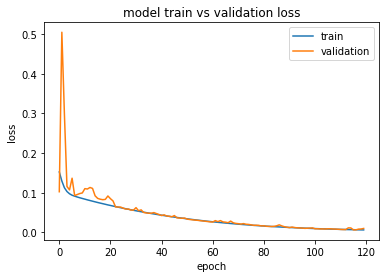

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687]
5 131
Train on 1555 samples, validate on 16 samples
Epoch 1/120
1555/1555 [==============================] - 42s 27ms/step - loss: 0.1437 - val_loss: 0.4791
Epoch 2/120
1555/1555 [==============================] - 0s 94us/step - loss: 0.1152 - val_loss: 0.1223
Epoch 3/120
1555/1555 [==============================] - 0s 98us/step - loss: 0.1061 - val_loss: 0.1342
Epoch 4/120
1555/1555 [==============================] - 0s 99us/step - loss: 0.1004 - val_loss: 0.1895
Epoch 5/120
1555/1555 [==============================] - 0s 93us/step - loss: 0.0969 - val_loss: 0.3200
Epoch 6/120
1555/1555 [==============================] - 0s 96us/step - loss: 0.0942 - val_loss: 0.4292
Epoch 7/120
1555/1555 [==============================] - 0s 94us/step - loss: 0.0920 - val_loss: 0.2811
Epoch 8/120
1555/1555 [==============================] - 0s 97us/step - loss: 0.0900 - val_loss: 0.2196
Epoch 9/120
1555/1555 [=========

1555/1555 [==============================] - 0s 98us/step - loss: 0.0179 - val_loss: 0.0194
Epoch 78/120
1555/1555 [==============================] - 0s 95us/step - loss: 0.0175 - val_loss: 0.0190
Epoch 79/120
1555/1555 [==============================] - 0s 92us/step - loss: 0.0170 - val_loss: 0.0177
Epoch 80/120
1555/1555 [==============================] - 0s 98us/step - loss: 0.0166 - val_loss: 0.0257
Epoch 81/120
1555/1555 [==============================] - 0s 100us/step - loss: 0.0162 - val_loss: 0.0159
Epoch 82/120
1555/1555 [==============================] - 0s 93us/step - loss: 0.0158 - val_loss: 0.0221
Epoch 83/120
1555/1555 [==============================] - 0s 95us/step - loss: 0.0154 - val_loss: 0.0279
Epoch 84/120
1555/1555 [==============================] - 0s 94us/step - loss: 0.0150 - val_loss: 0.0303
Epoch 85/120
1555/1555 [==============================] - 0s 95us/step - loss: 0.0146 - val_loss: 0.0172
Epoch 86/120
1555/1555 [==============================] - 0s 94us/s

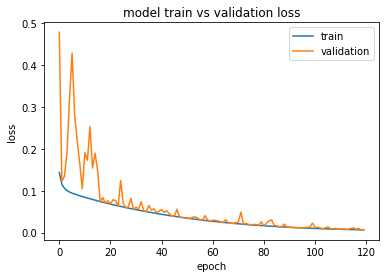

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813]
6 131
Train on 1556 samples, validate on 16 samples
Epoch 1/120
1556/1556 [==============================] - 43s 28ms/step - loss: 0.1575 - val_loss: 0.1466
Epoch 2/120
1556/1556 [==============================] - 0s 96us/step - loss: 0.1443 - val_loss: 0.1032
Epoch 3/120
1556/1556 [==============================] - 0s 101us/step - loss: 0.1311 - val_loss: 0.1144
Epoch 4/120
1556/1556 [==============================] - 0s 102us/step - loss: 0.1201 - val_loss: 0.1666
Epoch 5/120
1556/1556 [==============================] - 0s 97us/step - loss: 0.1109 - val_loss: 0.1084
Epoch 6/120
1556/1556 [==============================] - 0s 99us/step - loss: 0.1039 - val_loss: 0.1000
Epoch 7/120
1556/1556 [==============================] - 0s 96us/step - loss: 0.0982 - val_loss: 0.0955
Epoch 8/120
1556/1556 [==============================] - 0s 96us/step - loss: 0.0940 - val_loss: 0.0917
Epoch 9/120
1556/

1556/1556 [==============================] - 0s 100us/step - loss: 0.0179 - val_loss: 0.0185
Epoch 78/120
1556/1556 [==============================] - 0s 93us/step - loss: 0.0174 - val_loss: 0.0193
Epoch 79/120
1556/1556 [==============================] - 0s 95us/step - loss: 0.0170 - val_loss: 0.0216
Epoch 80/120
1556/1556 [==============================] - 0s 100us/step - loss: 0.0165 - val_loss: 0.0190
Epoch 81/120
1556/1556 [==============================] - 0s 101us/step - loss: 0.0161 - val_loss: 0.0175
Epoch 82/120
1556/1556 [==============================] - 0s 99us/step - loss: 0.0157 - val_loss: 0.0167
Epoch 83/120
1556/1556 [==============================] - 0s 96us/step - loss: 0.0153 - val_loss: 0.0150
Epoch 84/120
1556/1556 [==============================] - 0s 98us/step - loss: 0.0149 - val_loss: 0.0149
Epoch 85/120
1556/1556 [==============================] - 0s 100us/step - loss: 0.0146 - val_loss: 0.0147
Epoch 86/120
1556/1556 [==============================] - 0s 99u

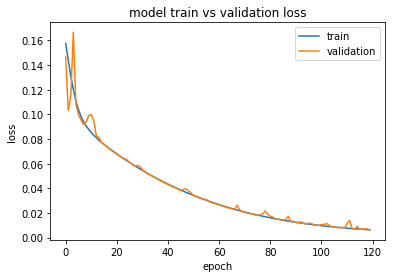

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813, -0.0035354078]
7 131
Train on 1557 samples, validate on 16 samples
Epoch 1/120
1557/1557 [==============================] - 44s 28ms/step - loss: 0.1433 - val_loss: 0.1267
Epoch 2/120
1557/1557 [==============================] - 0s 93us/step - loss: 0.1144 - val_loss: 0.5401
Epoch 3/120
1557/1557 [==============================] - 0s 100us/step - loss: 0.1050 - val_loss: 0.4901
Epoch 4/120
1557/1557 [==============================] - 0s 96us/step - loss: 0.0995 - val_loss: 0.3790
Epoch 5/120
1557/1557 [==============================] - 0s 95us/step - loss: 0.0962 - val_loss: 0.6155
Epoch 6/120
1557/1557 [==============================] - 0s 98us/step - loss: 0.0936 - val_loss: 0.4468
Epoch 7/120
1557/1557 [==============================] - 0s 100us/step - loss: 0.0912 - val_loss: 0.4193
Epoch 8/120
1557/1557 [==============================] - 0s 97us/step - loss: 0.0893 - val_loss: 0.1466
Ep

1557/1557 [==============================] - 0s 104us/step - loss: 0.0179 - val_loss: 0.0176
Epoch 78/120
1557/1557 [==============================] - 0s 97us/step - loss: 0.0175 - val_loss: 0.0182
Epoch 79/120
1557/1557 [==============================] - 0s 95us/step - loss: 0.0170 - val_loss: 0.0171
Epoch 80/120
1557/1557 [==============================] - 0s 99us/step - loss: 0.0166 - val_loss: 0.0179
Epoch 81/120
1557/1557 [==============================] - 0s 101us/step - loss: 0.0162 - val_loss: 0.0171
Epoch 82/120
1557/1557 [==============================] - 0s 94us/step - loss: 0.0158 - val_loss: 0.0158
Epoch 83/120
1557/1557 [==============================] - 0s 100us/step - loss: 0.0154 - val_loss: 0.0157
Epoch 84/120
1557/1557 [==============================] - 0s 102us/step - loss: 0.0150 - val_loss: 0.0148
Epoch 85/120
1557/1557 [==============================] - 0s 97us/step - loss: 0.0146 - val_loss: 0.0143
Epoch 86/120
1557/1557 [==============================] - 0s 93u

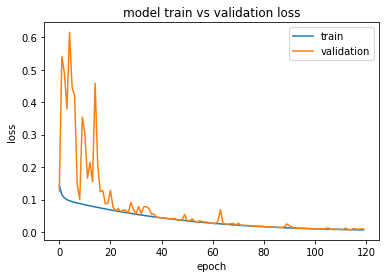

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813, -0.0035354078, 0.013222691]
8 131
Train on 1558 samples, validate on 16 samples
Epoch 1/120
1558/1558 [==============================] - 44s 28ms/step - loss: 0.1578 - val_loss: 0.1223
Epoch 2/120
1558/1558 [==============================] - 0s 97us/step - loss: 0.1456 - val_loss: 0.1125
Epoch 3/120
1558/1558 [==============================] - 0s 98us/step - loss: 0.1333 - val_loss: 0.1267
Epoch 4/120
1558/1558 [==============================] - 0s 98us/step - loss: 0.1229 - val_loss: 0.1986
Epoch 5/120
1558/1558 [==============================] - 0s 99us/step - loss: 0.1135 - val_loss: 0.1259
Epoch 6/120
1558/1558 [==============================] - 0s 98us/step - loss: 0.1059 - val_loss: 0.1004
Epoch 7/120
1558/1558 [==============================] - 0s 98us/step - loss: 0.0998 - val_loss: 0.1238
Epoch 8/120
1558/1558 [==============================] - 0s 105us/step - loss: 0.0951 - val_los

1558/1558 [==============================] - 0s 105us/step - loss: 0.0179 - val_loss: 0.0177
Epoch 78/120
1558/1558 [==============================] - 0s 99us/step - loss: 0.0174 - val_loss: 0.0173
Epoch 79/120
1558/1558 [==============================] - 0s 97us/step - loss: 0.0169 - val_loss: 0.0172
Epoch 80/120
1558/1558 [==============================] - 0s 99us/step - loss: 0.0166 - val_loss: 0.0165
Epoch 81/120
1558/1558 [==============================] - 0s 96us/step - loss: 0.0161 - val_loss: 0.0161
Epoch 82/120
1558/1558 [==============================] - 0s 94us/step - loss: 0.0157 - val_loss: 0.0155
Epoch 83/120
1558/1558 [==============================] - 0s 96us/step - loss: 0.0153 - val_loss: 0.0153
Epoch 84/120
1558/1558 [==============================] - 0s 96us/step - loss: 0.0149 - val_loss: 0.0162
Epoch 85/120
1558/1558 [==============================] - 0s 96us/step - loss: 0.0146 - val_loss: 0.0148
Epoch 86/120
1558/1558 [==============================] - 0s 99us/s

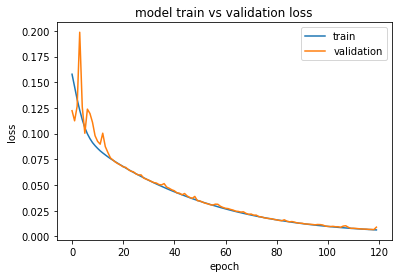

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813, -0.0035354078, 0.013222691, 0.013754235]
9 131
Train on 1559 samples, validate on 16 samples
Epoch 1/120
1559/1559 [==============================] - 46s 29ms/step - loss: 0.1468 - val_loss: 0.1110
Epoch 2/120
1559/1559 [==============================] - 0s 91us/step - loss: 0.1194 - val_loss: 0.1050
Epoch 3/120
1559/1559 [==============================] - 0s 92us/step - loss: 0.1103 - val_loss: 0.1115
Epoch 4/120
1559/1559 [==============================] - 0s 90us/step - loss: 0.1039 - val_loss: 0.1064
Epoch 5/120
1559/1559 [==============================] - 0s 90us/step - loss: 0.0995 - val_loss: 0.1266
Epoch 6/120
1559/1559 [==============================] - 0s 90us/step - loss: 0.0965 - val_loss: 0.1424
Epoch 7/120
1559/1559 [==============================] - 0s 90us/step - loss: 0.0938 - val_loss: 0.0973
Epoch 8/120
1559/1559 [==============================] - 0s 91us/step - loss: 0.09

1559/1559 [==============================] - 0s 96us/step - loss: 0.0179 - val_loss: 0.0200
Epoch 78/120
1559/1559 [==============================] - 0s 100us/step - loss: 0.0174 - val_loss: 0.0193
Epoch 79/120
1559/1559 [==============================] - 0s 99us/step - loss: 0.0170 - val_loss: 0.0183
Epoch 80/120
1559/1559 [==============================] - 0s 115us/step - loss: 0.0165 - val_loss: 0.0167
Epoch 81/120
1559/1559 [==============================] - 0s 108us/step - loss: 0.0161 - val_loss: 0.0162
Epoch 82/120
1559/1559 [==============================] - 0s 100us/step - loss: 0.0157 - val_loss: 0.0157
Epoch 83/120
1559/1559 [==============================] - 0s 94us/step - loss: 0.0153 - val_loss: 0.0154
Epoch 84/120
1559/1559 [==============================] - 0s 90us/step - loss: 0.0149 - val_loss: 0.0148
Epoch 85/120
1559/1559 [==============================] - 0s 98us/step - loss: 0.0146 - val_loss: 0.0144
Epoch 86/120
1559/1559 [==============================] - 0s 102

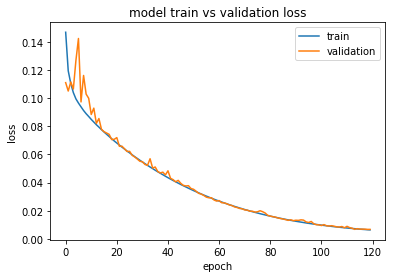

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813, -0.0035354078, 0.013222691, 0.013754235, 0.011457182]
10 131
Train on 1560 samples, validate on 16 samples
Epoch 1/120
1560/1560 [==============================] - 45s 29ms/step - loss: 0.1586 - val_loss: 0.1578
Epoch 2/120
1560/1560 [==============================] - 0s 100us/step - loss: 0.1493 - val_loss: 0.1567
Epoch 3/120
1560/1560 [==============================] - 0s 100us/step - loss: 0.1395 - val_loss: 0.1524
Epoch 4/120
1560/1560 [==============================] - 0s 103us/step - loss: 0.1300 - val_loss: 0.1373
Epoch 5/120
1560/1560 [==============================] - 0s 108us/step - loss: 0.1209 - val_loss: 0.1224
Epoch 6/120
1560/1560 [==============================] - 0s 101us/step - loss: 0.1127 - val_loss: 0.1067
Epoch 7/120
1560/1560 [==============================] - 0s 102us/step - loss: 0.1052 - val_loss: 0.0963
Epoch 8/120
1560/1560 [==============================] - 0s 10

1560/1560 [==============================] - 0s 111us/step - loss: 0.0183 - val_loss: 0.0184
Epoch 77/120
1560/1560 [==============================] - 0s 106us/step - loss: 0.0179 - val_loss: 0.0181
Epoch 78/120
1560/1560 [==============================] - 0s 104us/step - loss: 0.0174 - val_loss: 0.0189
Epoch 79/120
1560/1560 [==============================] - 0s 105us/step - loss: 0.0170 - val_loss: 0.0172
Epoch 80/120
1560/1560 [==============================] - 0s 101us/step - loss: 0.0166 - val_loss: 0.0161
Epoch 81/120
1560/1560 [==============================] - 0s 98us/step - loss: 0.0161 - val_loss: 0.0157
Epoch 82/120
1560/1560 [==============================] - 0s 102us/step - loss: 0.0157 - val_loss: 0.0153
Epoch 83/120
1560/1560 [==============================] - 0s 97us/step - loss: 0.0153 - val_loss: 0.0149
Epoch 84/120
1560/1560 [==============================] - 0s 99us/step - loss: 0.0149 - val_loss: 0.0145
Epoch 85/120
1560/1560 [==============================] - 0s 1

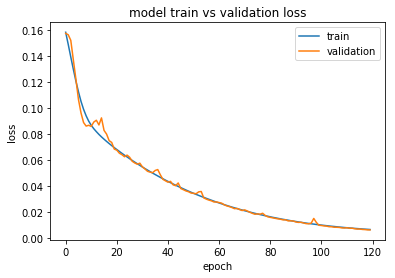

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813, -0.0035354078, 0.013222691, 0.013754235, 0.011457182, 0.00081274315]
11 131
Train on 1561 samples, validate on 16 samples
Epoch 1/120
1561/1561 [==============================] - 46s 30ms/step - loss: 0.1485 - val_loss: 0.1197
Epoch 2/120
1561/1561 [==============================] - 0s 99us/step - loss: 0.1172 - val_loss: 0.5213
Epoch 3/120
1561/1561 [==============================] - 0s 98us/step - loss: 0.1054 - val_loss: 0.1186
Epoch 4/120
1561/1561 [==============================] - 0s 105us/step - loss: 0.1005 - val_loss: 0.0952
Epoch 5/120
1561/1561 [==============================] - 0s 102us/step - loss: 0.0974 - val_loss: 0.1154
Epoch 6/120
1561/1561 [==============================] - 0s 99us/step - loss: 0.0948 - val_loss: 0.0973
Epoch 7/120
1561/1561 [==============================] - 0s 100us/step - loss: 0.0925 - val_loss: 0.0900
Epoch 8/120
1561/1561 [===========================

1561/1561 [==============================] - 0s 112us/step - loss: 0.0184 - val_loss: 0.0178
Epoch 77/120
1561/1561 [==============================] - 0s 99us/step - loss: 0.0179 - val_loss: 0.0190
Epoch 78/120
1561/1561 [==============================] - 0s 102us/step - loss: 0.0175 - val_loss: 0.0163
Epoch 79/120
1561/1561 [==============================] - 0s 102us/step - loss: 0.0170 - val_loss: 0.0157
Epoch 80/120
1561/1561 [==============================] - 0s 98us/step - loss: 0.0166 - val_loss: 0.0184
Epoch 81/120
1561/1561 [==============================] - 0s 112us/step - loss: 0.0162 - val_loss: 0.0151
Epoch 82/120
1561/1561 [==============================] - 0s 111us/step - loss: 0.0157 - val_loss: 0.0154
Epoch 83/120
1561/1561 [==============================] - 0s 107us/step - loss: 0.0154 - val_loss: 0.0160
Epoch 84/120
1561/1561 [==============================] - 0s 98us/step - loss: 0.0150 - val_loss: 0.0145
Epoch 85/120
1561/1561 [==============================] - 0s 1

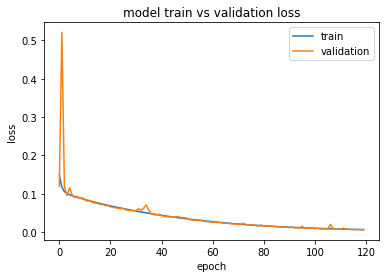

[0.0018289835, 0.0041467207, 0.01602321, -0.0004998819, 0.0022833233, 0.022574687, -0.00971813, -0.0035354078, 0.013222691, 0.013754235, 0.011457182, 0.00081274315, 0.0015892646]
12 131
Train on 1562 samples, validate on 16 samples
Epoch 1/120
1562/1562 [==============================] - 51s 33ms/step - loss: 0.1548 - val_loss: 0.1555
Epoch 2/120
1562/1562 [==============================] - 0s 106us/step - loss: 0.1297 - val_loss: 0.1579
Epoch 3/120
1562/1562 [==============================] - 0s 101us/step - loss: 0.1132 - val_loss: 0.1131
Epoch 4/120
1562/1562 [==============================] - 0s 103us/step - loss: 0.1021 - val_loss: 0.1087
Epoch 5/120
1562/1562 [==============================] - 0s 110us/step - loss: 0.0960 - val_loss: 0.1058
Epoch 6/120
1562/1562 [==============================] - 0s 120us/step - loss: 0.0935 - val_loss: 0.0948
Epoch 7/120
1562/1562 [==============================] - 0s 124us/step - loss: 0.0912 - val_loss: 0.0970
Epoch 8/120
1562/1562 [==========

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
import statsmodels.api as sm
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization, LeakyReLU

scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))
end = int(len(var1)/10)
for i in range(1, 2):
    variables_in = feature_importances.index[:10]
#     trainX = train1[variables_in]
#     trainY = train1['y_return_ratio']
    
#     valX = val[variables_in]
#     valY = val['y_return_ratio']
    predictions= []
    for i in range(len(test)):
        trainX = pd.concat([train, val1, val2, val3, test[:i]]).asfreq('B', method='bfill').fillna(method='bfill')[variables_in]
        trainY = pd.concat([train, val1, val2, val3, test[:i]]).asfreq('B', method='bfill').fillna(method='bfill')['y_return_ratio']
        
        testX = test[i:i+1][variables_in]
        testY = test[i:i+1]['y_return_ratio']

        features_set = scalerX.fit_transform(trainX)
        features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
        labels = scalerY.fit_transform(np.array(trainY).reshape(-1, 1))

        test_features_set = scalerX.transform(testX)
        test_features_set = np.reshape(test_features_set, (test_features_set.shape[0], test_features_set.shape[1], 1))
        
        model = Sequential()

        model.add(LSTM(units=features_set.shape[1], return_sequences=True, kernel_initializer='zeros', bias_regularizer=l2(0.01), input_shape=(features_set.shape[1], 1)))
        model.add(BatchNormalization()) 
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        model.add(LSTM(units=16, activity_regularizer=l2(0.01)))
        model.add(BatchNormalization()) 
        model.add(LeakyReLU()) 
        model.add(Dense(1)) 
        model.add(Dense(units = 1, activation='linear'))

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12, restore_best_weights=True)
        opt = Adam(lr=0.001)

        model.compile(optimizer = opt, loss = 'mse')
        history = model.fit(features_set, labels, epochs = 120, batch_size = int(len(trainX)/10), validation_split=0.01, callbacks=[es], verbose=1)
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model train vs validation loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()
        
        predictions.append(scalerY.inverse_transform(model.predict(test_features_set).reshape(-1, 1))[0][0])
        print(predictions)
        print(i, len(test))
#     predictions = scalerY.inverse_transform(predictions)

#     plt.plot(predictions)

[0.008903278, -0.032675277, 0.04235153, 0.036092643, -0.004688418, -0.03711787, -0.0047198986, -0.009877734, 0.0062408405, 0.036028914, 0.029812118, -0.0021414144, 0.017135374, 0.0024796883, 0.005804692, 0.019609781, 0.0091189705, -0.0069311983, 0.0057088765, -0.012167508, 0.020307751, 0.00684698, -0.0055778986, 0.025141273, 0.008744351, 0.01026787, -0.012508877, 0.009650071, 0.0046120486, 0.03425779, 0.0067753894, 0.010389575, 0.024443429, -0.00050844793, 0.015204684, 0.041094363, 0.02165386, 0.0034978443, -0.0032461158, 0.015790652, 0.026805993, 0.003858925, 0.0026992355, -0.0016702048, 0.0064851246, 0.019299263, 0.025513832, 0.0033256048, 0.006790786, 0.019774752, 0.0009187666, -0.0017748598, 0.032004945, 0.03233742, -0.0043220557, 0.008376113, -0.012315826, 0.008600353, -0.006794254, 0.0042473283, 0.051600162, 0.014699275, 0.0015590944, -0.0013505155, 0.0142194405, -0.0036652423, -0.002404799, -0.008693348, 0.014949243, 0.0026847473, -0.0293064, -0.012420206, -0.007067386, -0.00410

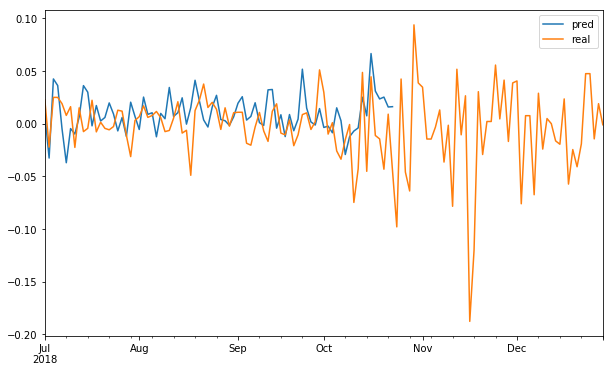

0.026740695440405016


In [9]:
print(predictions)
plt.figure(figsize=(10,6))
pd.Series(predictions, index=test.index[:len(predictions)]).plot(label='pred')
test['y_return_ratio'].plot(label="real")
plt.legend()
plt.show()
print(rmse(predictions, test.iloc[:len(predictions)]['y_return_ratio']))

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

In [2]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances

In [ ]:
# X_train1 = train1[var1]
# y_train1 = train1[target]
# X_test1 = test[var1]
# y_test1 = test[target]

# model = ExtraTreesRegressor()
# model.fit(X_train1, y_train1)
# feature_importances = pd.DataFrame(model.feature_importances_, index=X_train1.columns, columns=['importance']).sort_values('importance', ascending=False)
# feature_importances